In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

import torch
import gradio as gr

import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag, ne_chunk
from nltk.corpus import stopwords
nltk.download('stopwords')
from tqdm import tqdm
import re
import string
from nltk.stem import PorterStemmer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from collections import Counter
import plotly.express as px
nltk.download('wordnet')
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
from nltk.stem import WordNetLemmatizer    # lemmatize
from wordcloud import WordCloud, STOPWORDS
from nltk.parse import DependencyGraph
import string

import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dangnhathuy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/dangnhathuy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/dangnhathuy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/dangnhathuy/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/dangnh

In [3]:
import ast
data = pd.read_csv('/Users/dangnhathuy/Downloads/ICT/endterm/data/FinalRatingsOver.csv')
data.head(5)

,review,label
0,outlet great better dish servic yum garlic amb...,1
1,summer pay qualiti tax get realli time visit s...,0
2,varieti toastizza differ theyv burger mark the...,1
3,blue recommend cool sizzl qualiti could dazzl ...,1
4,dri realli stale month small meet unfortun pla...,1


In [4]:
X = data['review']
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [6]:
path = './trained_over_model'
model = AutoModelForSequenceClassification.from_pretrained(path)

In [7]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [8]:
def evaluate(model, tokenizer, X, y, device, batch_size=32):
    model.to(device)
    model.eval()

    accuracies, precisions, recalls, f1s = [], [], [], []
    all_predictions, all_true_labels = [], []

    for i in range(0, len(X), batch_size):
        batch_X = X[i:i + batch_size]
        batch_y = y[i:i + batch_size]

        inputs = tokenizer(batch_X.tolist(), padding=True, truncation=True, return_tensors="pt").to(device)
        labels = torch.tensor(batch_y.tolist()).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            predictions = torch.argmax(outputs.logits, dim=-1)
            precision, recall, f1, _ = precision_recall_fscore_support(labels.cpu(), predictions.cpu(), average='binary')
            accuracy = accuracy_score(labels.cpu(), predictions.cpu())

            accuracies.append(accuracy)
            precisions.append(precision)
            recalls.append(recall)
            f1s.append(f1)

            all_predictions.extend(predictions.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    # Calculate average metrics
    avg_accuracy = sum(accuracies) / len(accuracies)
    avg_precision = sum(precisions) / len(precisions)
    avg_recall = sum(recalls) / len(recalls)
    avg_f1 = sum(f1s) / len(f1s)

    return avg_accuracy, avg_precision, avg_recall, avg_f1, all_predictions, all_true_labels

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
acc, precision, recall, f1, all_predictions, all_true_labels  = evaluate(model, tokenizer, X_test, y_test, device, batch_size=32)

In [ ]:
print(f"Accuracy: \t {acc:.2f}")
print(f"Precision: \t {precision:.2f}")
print(f"Recall: \t {recall:.2f}")
print(f"F1 Score: \t {f1:.2f}")

Accuracy: 	 0.94
Precision: 	 0.93
Recall: 	 0.96
F1 Score: 	 0.94


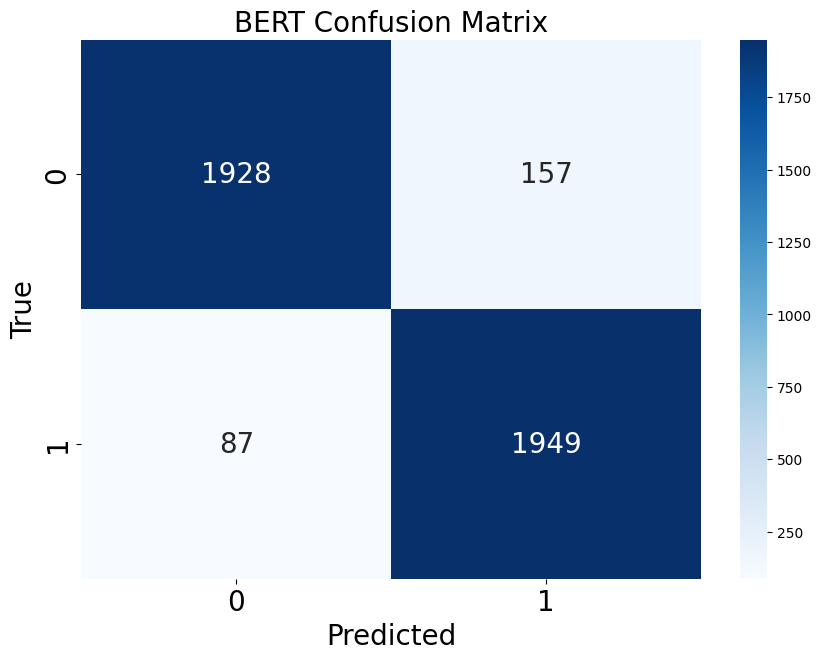

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
#Plot
cm = confusion_matrix(all_true_labels, all_predictions)
plt.figure(figsize=(10,7))
sns.heatmap(cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        annot_kws={"size": 20})
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('True', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('BERT Confusion Matrix', fontsize=20)
plt.savefig('BERT Confusion Matrix.pdf')
plt.show()

In [ ]:
path1 = '/Users/dangnhathuy/Downloads/ICT/endterm/data/Restaurant_Reviews.tsv'
data1 = pd.read_csv(path1,sep='\t')
data1

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1
...,...,...
995,I think food should have flavor and texture an...,0
996,Appetite instantly gone.,0
997,Overall I was not impressed and would not go b...,0
998,"The whole experience was underwhelming, and I ...",0


In [ ]:
def drop_duplicate_reviews(data, text_col, min_length=0, min_count=2):
    review_counts_df = data[text_col].value_counts().reset_index()
    review_counts_df.columns = [text_col, 'count']
    mask = (review_counts_df[text_col].str.len() >= min_length) & (review_counts_df['count'] >= min_count)
    rating_df = data[~data[text_col].isin(review_counts_df[mask][text_col])].reset_index(drop=True)
    return rating_df

def text_processing(text):
    processed_text = text.lower()
    processed_text = re.sub(r'<[^>]+>', '', processed_text)
    processed_text = re.sub(r'[^a-zA-Z0-9]', ' ', processed_text)
    words = list(set(processed_text.split()))
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    processed_text = ' '.join(words)
    processed_text = re.sub(r'\d+', 'NUM', processed_text)
    return processed_text

def main_processing_data(data):
    result_df = drop_duplicate_reviews(data, text_col='Review')
    print('Remove dulicate data sucessfully!!!')
    result_df['Review'] = result_df.Review.apply(text_processing)
    print('\nProcess text successfully!!!')
    result_df = result_df[result_df['Review']!='']
    print('\nDrop NaN rows sucessfully!!!')
    return result_df

df1 = main_processing_data(data1)
df1

Remove dulicate data sucessfully!!!

Process text successfully!!!

Drop NaN rows sucessfully!!!


,Review,Liked
0,love place wow,1
1,good crust,0
2,tasti textur nasti,0
3,steve late bank rick stop love recommend holid...,1
4,great price menu select,1
...,...,...
987,food think flavor lack textur,0
988,gone appetit instantli,0
989,overal back go impress would,0
990,experi time think whole next sushi underwhelm ...,0


In [ ]:
X1 = df1['Review']
y1 = df1['Liked']

In [ ]:
type(y1)

pandas.core.series.Series

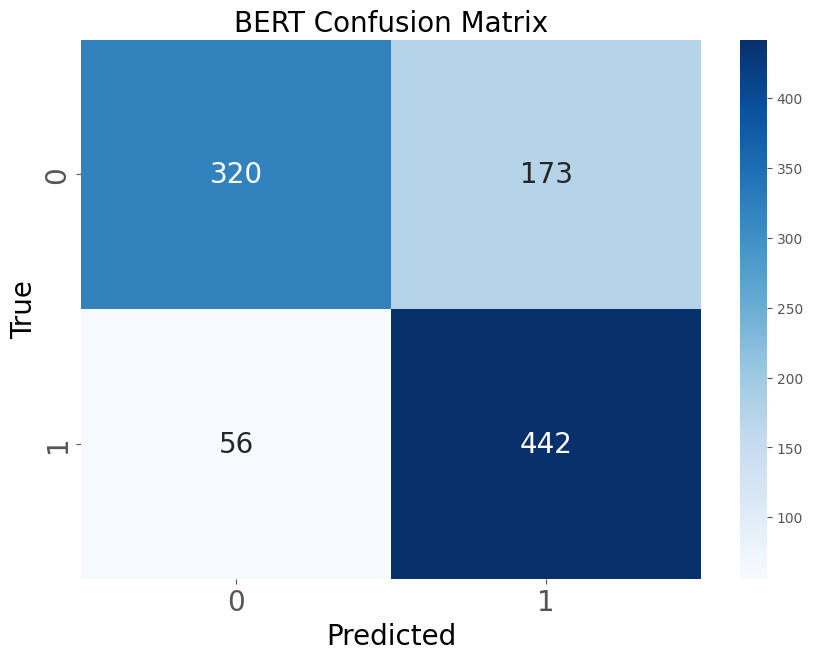

In [ ]:
acc1, precision1, recall1, f11, all_predictions1, all_true_labels1  = evaluate(model, tokenizer, X1, y1, device, batch_size=32)

#Plot
cm = confusion_matrix(all_true_labels1, all_predictions1)
plt.figure(figsize=(10,7))
sns.heatmap(cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        annot_kws={"size": 20})
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('True', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('BERT Confusion Matrix', fontsize=20)
plt.savefig('BERT Confusion Matrix.pdf')
plt.show()

Performance on Dataset 1:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0
Confusion Matrix:
[[4 0]
 [0 5]]

Performance on Dataset 2:
Accuracy: 0.7777777777777778
Precision: 0.8
Recall: 0.8
F1-score: 0.8000000000000002
Confusion Matrix:
[[3 1]
 [1 4]]


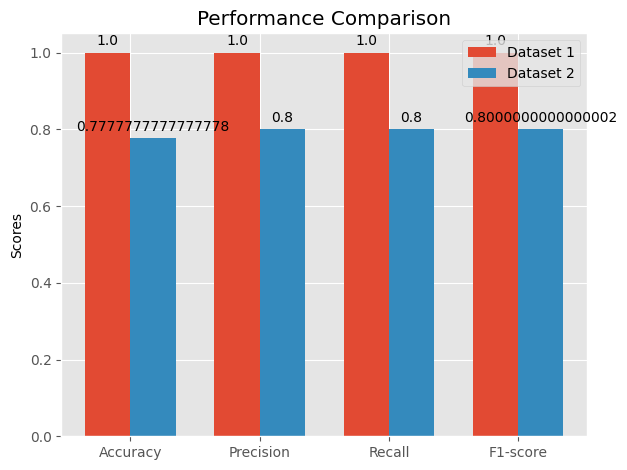

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Đánh giá hiệu suất của mô hình trên hai bộ dữ liệu khác nhau
y_true_1 = [0, 1, 0, 1, 1, 0, 1, 0, 1]
y_pred_1 = [0, 1, 0, 1, 1, 0, 1, 0, 1]

y_true_2 = [0, 1, 0, 1, 1, 0, 1, 0, 1]
y_pred_2 = [0, 1, 1, 1, 1, 0, 1, 0, 0]

# Tính các thông số đánh giá
accuracy_1 = accuracy_score(y_true_1, y_pred_1)
accuracy_2 = accuracy_score(y_true_2, y_pred_2)

precision_1 = precision_score(y_true_1, y_pred_1)
precision_2 = precision_score(y_true_2, y_pred_2)

recall_1 = recall_score(y_true_1, y_pred_1)
recall_2 = recall_score(y_true_2, y_pred_2)

f1_1 = f1_score(y_true_1, y_pred_1)
f1_2 = f1_score(y_true_2, y_pred_2)

# Tính confusion matrix
cm_1 = confusion_matrix(y_true_1, y_pred_1)
cm_2 = confusion_matrix(y_true_2, y_pred_2)

# Hiển thị kết quả
print("Performance on Dataset 1:")
print("Accuracy:", accuracy_1)
print("Precision:", precision_1)
print("Recall:", recall_1)
print("F1-score:", f1_1)
print("Confusion Matrix:")
print(cm_1)

print("\nPerformance on Dataset 2:")
print("Accuracy:", accuracy_2)
print("Precision:", precision_2)
print("Recall:", recall_2)
print("F1-score:", f1_2)
print("Confusion Matrix:")
print(cm_2)

# Vẽ biểu đồ so sánh
labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values_1 = [accuracy_1, precision_1, recall_1, f1_1]
values_2 = [accuracy_2, precision_2, recall_2, f1_2]

x = np.arange(len(labels))  # Vị trí của các nhãn trên trục x

width = 0.35  # Kích thước của các cột

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, values_1, width, label='Dataset 1')
rects2 = ax.bar(x + width/2, values_2, width, label='Dataset 2')

# Thêm tiêu đề và nhãn cho biểu đồ
ax.set_ylabel('Scores')
ax.set_title('Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Tạo chú thích
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()


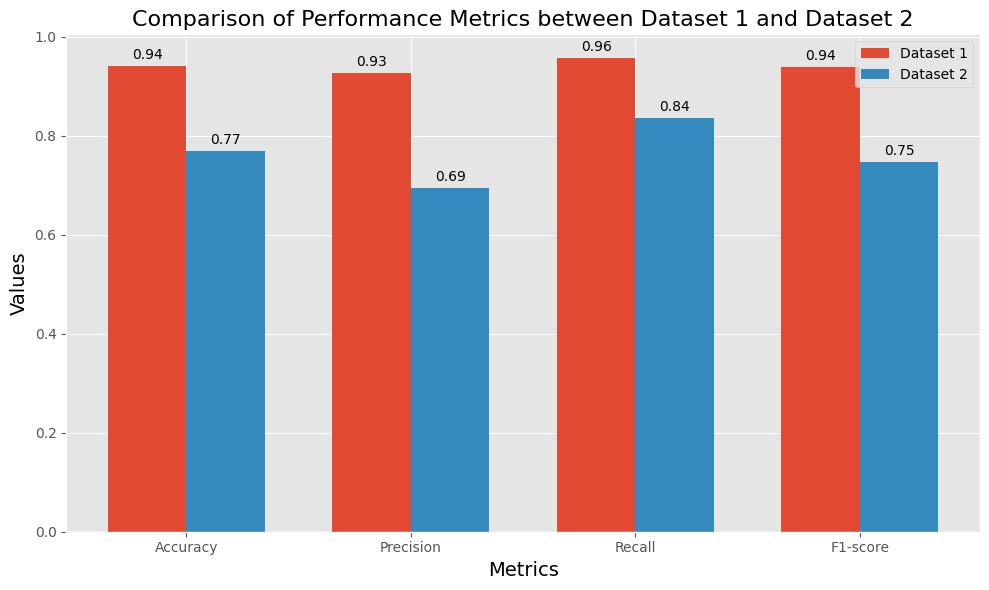

In [ ]:
# Số lượng các độ đo
num_metrics = len(metrics)

# Định dạng bar chart
bar_width = 0.35
index = range(num_metrics)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
bar1 = plt.bar(index, dataset1_values, bar_width, label='Dataset 1')
bar2 = plt.bar([i + bar_width for i in index], dataset2_values, bar_width, label='Dataset 2')

# Thêm tiêu đề và nhãn cho biểu đồ
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.title('Comparison of Performance Metrics between Dataset 1 and Dataset 2', fontsize=16)
plt.xticks([i + bar_width / 2 for i in index], metrics)
plt.legend()

# Hiển thị giá trị trên từng cột
for bar in [bar1, bar2]:
    for rect in bar:
        height = rect.get_height()
        plt.annotate('{}'.format(round(height, 2)),
                     xy=(rect.get_x() + rect.get_width() / 2, height),
                     xytext=(0, 3),
                     textcoords="offset points",
                     ha='center', va='bottom')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


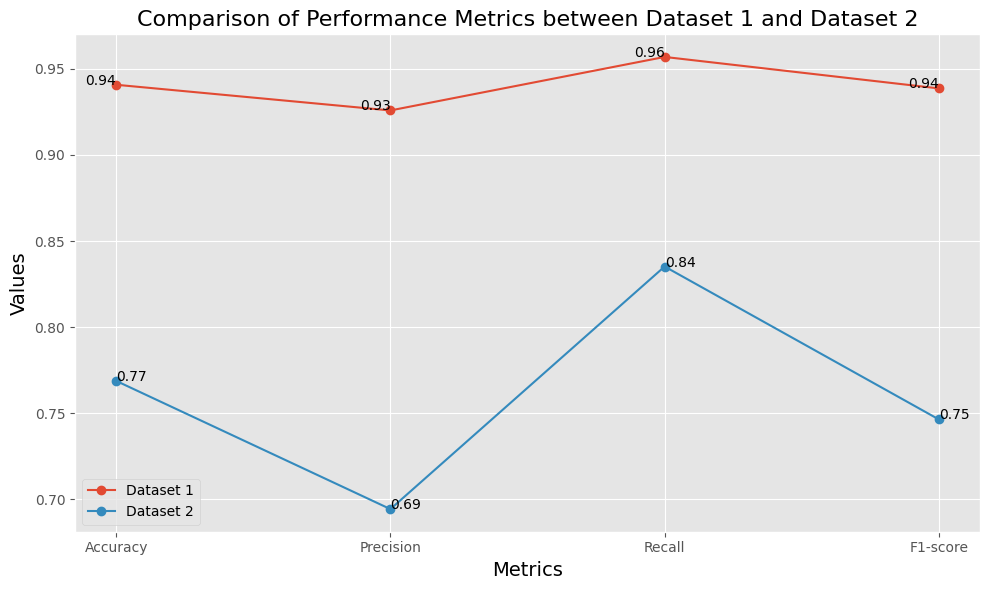

In [ ]:
import matplotlib.pyplot as plt

# Danh sách các độ đo và giá trị tương ứng trên Dataset 1 và Dataset 2
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
dataset1_values = [acc, precision, recall, f1]
dataset2_values = [acc1, precision1, recall1, f11]

# Số lượng các độ đo
num_metrics = len(metrics)

# Định dạng line chart
index = range(num_metrics)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(index, dataset1_values, marker='o', label='Dataset 1')
plt.plot(index, dataset2_values, marker='o', label='Dataset 2')

# Thêm tiêu đề và nhãn cho biểu đồ
plt.xlabel('Metrics', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.title('Comparison of Performance Metrics between Dataset 1 and Dataset 2', fontsize=16)
plt.xticks(index, metrics)
plt.legend()

# Hiển thị giá trị trên từng điểm trên đường line
for i in range(num_metrics):
    plt.text(index[i], dataset1_values[i], str(round(dataset1_values[i], 2)), ha='right')
    plt.text(index[i], dataset2_values[i], str(round(dataset2_values[i], 2)), ha='left')

# Hiển thị biểu đồ
plt.grid(True)
plt.tight_layout()
plt.show()
